# Area of Interest Sampler
* Create window sampler based on the area of interest (AOI)
* AOI is based on the grid IDs from the data split i.e., `train`, `validation`, and `test`
* Sample windows randomly given a size limit in pixel. The size of the sampled windows vary depending on the probablity proportional to the area (grid cells)

In [1]:
import rasterio
import geopandas as gpd
from gdl.datasets.benchmark import get_field_D_grid_split
from gdl.datasets.polygon import PolygonSplitter
from gdl.samplers.aoi_sampler import AoiSampler


# load raster image, 10m grids, and boundary shape (fenced area)
raster_image_path = '../../../field-D/d-RGB-9mm-reference.tif'
grid_path = '../../../field-D/grid-10m-squares/grid-10m-squares.shp'
fenced_area_path = '../../../field-D/boundary-shape/boundary-shape.shp'

ps = PolygonSplitter(grid_path=grid_path,
                     fenced_area_path=fenced_area_path)

train_indices, validation_indices, test_indices = get_field_D_grid_split()

train_polygon = ps.get_polygon_by_indices(grid_indices=train_indices)
validation_polygon = ps.get_polygon_by_indices(grid_indices=validation_indices)
test_polygon = ps.get_polygon_by_indices(grid_indices=test_indices)

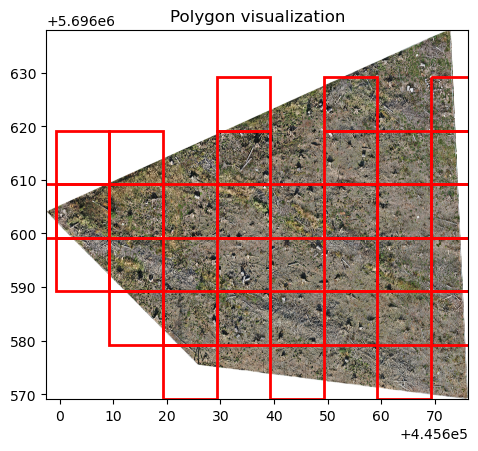

In [2]:
# visualize the train split area in grid cells
ps.plot(raster_image=raster_image_path,
        polygons=train_polygon)

In [3]:
# Load the raster image
with rasterio.open(raster_image_path) as src:
    raster_image = src.read(1)
    raster_transform = src.transform
    raster_res = src.res

# load boundary shape (fenced area) for visualization
fenced_area_shape = gpd.read_file(fenced_area_path)
fenced_area = fenced_area_shape.geometry.union_all()

In [4]:
# set size limits (min, max) of window size
size_lims = (128,256)
# convert pixel to crs according to the raster resolution
size_lims = (size_lims[0] * raster_res[0], size_lims[1] * raster_res[0])

# create aoi sampler based on the split and size limit
train_aoi_sampler = AoiSampler(train_polygon, fenced_area, size_lims)
validation_aoi_sampler = AoiSampler(validation_polygon, fenced_area, size_lims)
test_aoi_sampler = AoiSampler(test_polygon, fenced_area, size_lims)

In [5]:
# sample the window with the intersection threshold 90%,
# meaning that the window has to intersect with valid pixel areas at least 90%

intersec_threshold = 90
train_windows = [train_aoi_sampler.sample_window(intersection_percentage_th=intersec_threshold) 
                 for _ in range(1000)]
validation_windows = [validation_aoi_sampler.sample_window(intersection_percentage_th=intersec_threshold) 
                      for _ in range(50)]
test_windows = [test_aoi_sampler.sample_window(intersection_percentage_th=intersec_threshold) 
                for _ in range(100)]

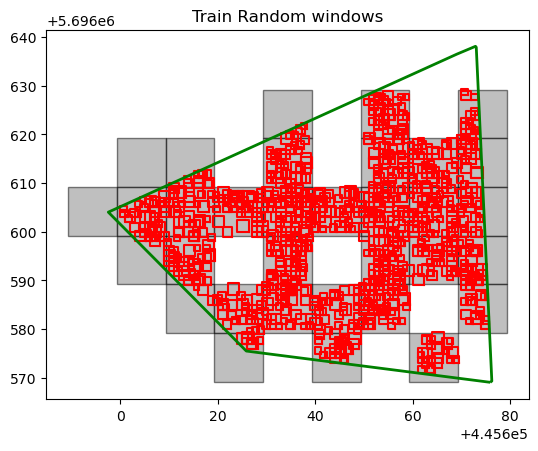

In [6]:
# show train windows
train_aoi_sampler.show_windows(train_polygon, train_windows, 
             boundary_shape=fenced_area,
             title='Train Random windows')

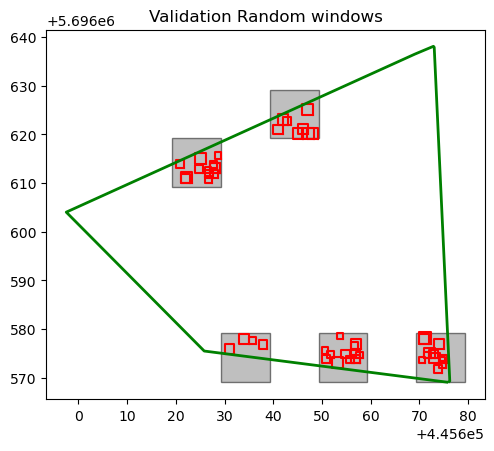

In [7]:
# show validation windows
validation_aoi_sampler.show_windows(validation_polygon, validation_windows, 
             boundary_shape=fenced_area,
             title='Validation Random windows')

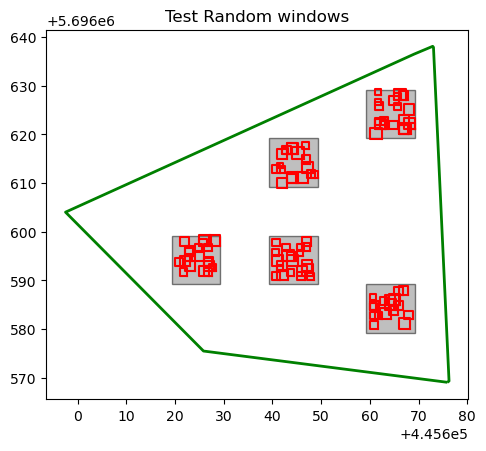

In [8]:
# show test windows
test_aoi_sampler.show_windows(test_polygon, test_windows, 
             boundary_shape=fenced_area,
             title='Test Random windows')